In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import ParameterSampler


# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/filter_ship.csv')

# created_at을 datetime으로 변환하고 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 독립 변수와 타겟 변수 설정
target_columns = ["lat", "lon"]  # 타겟 변수
independent_columns = ["turn", "speed", "accuracy", "lon", "lat", "course", "heading", "time_diff"]

# 타겟 변수 스케일링 (StandardScaler)
scaler_target = StandardScaler()
data[target_columns] = scaler_target.fit_transform(data[target_columns])

# time_diff만 MinMaxScaler 적용
scaler_time_diff = MinMaxScaler()
data["time_diff"] = scaler_time_diff.fit_transform(data[["time_diff"]])

# 시계열 데이터 변환
time_steps = 5
X, y = [], []
for i in range(len(data) - time_steps):
    # 입력 데이터: 독립변수 포함
    X.append(data.iloc[i:i + time_steps][independent_columns].values)
    # 출력 데이터: 타겟 변수 포함
    y.append(data.iloc[i + time_steps][target_columns].values)

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 결과 출력
print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (36824, 5, 8), y 크기: (36824, 2)


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import ParameterSampler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/filter_ship.csv')

# created_at 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 독립 변수와 타겟 변수 설정
selected_columns = ["heading", "course", "speed", "time_diff", "lat", "lon"]  # 위도와 경도 포함
target_columns = ["lat", "lon"]  # 타겟 변수

# 위도와 경도만 스케일링
scaler = StandardScaler()
data[["lat", "lon"]] = scaler.fit_transform(data[["lat", "lon"]])

# 시계열 데이터 변환
time_steps = 5
X, y = [], []
for i in range(len(data) - time_steps):
    # 선택된 독립 변수만 사용
    X.append(data.iloc[i:i + time_steps][selected_columns].values)
    y.append(data.iloc[i + time_steps][target_columns].values)

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 결과 출력
print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (36824, 5, 6), y 크기: (36824, 2)


In [5]:
# 데이터 분할 (학습/테스트만 나누기)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (29459, 5, 6), (29459, 2)
Test 데이터 크기: (7365, 5, 6), (7365, 2)


In [6]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [7]:

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0336
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0248
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0218
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.0488
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.5259
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0069
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0304
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 0.0144


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0221
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 64}, Loss: 0.0906
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 128}, Loss: 0.7920
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.0643
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0103
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0141
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 1.0350


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0267
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0131
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 128}, Loss: 0.3604
Params: {'num_layers': 4, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0184
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.1920
최적 파라미터: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, 손실: 0.0069


In [8]:
# 최적 파라미터
best_params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}

# 모델 정의
best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()

# 첫 번째 단계 학습
initial_lr = best_params['learning_rate']
optimizer = optim.Adam(best_model.parameters(), lr=initial_lr)

print("Stage 1: High Learning Rate Training")
num_epochs_stage1 = 50
for epoch in range(num_epochs_stage1):
    train_loss = 0.0
    best_model.train()
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 1 - Epoch [{epoch+1}/{num_epochs_stage1}], Loss: {avg_loss:.4f}")

# 두 번째 단계 학습
new_lr = 0.001  # 낮은 학습률
optimizer = optim.Adam(best_model.parameters(), lr=new_lr)

print("\nStage 2: Low Learning Rate Training")
num_epochs_stage2 = 50
for epoch in range(num_epochs_stage2):
    train_loss = 0.0
    best_model.train()
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 2 - Epoch [{epoch+1}/{num_epochs_stage2}], Loss: {avg_loss:.4f}")


Stage 1: High Learning Rate Training
Stage 1 - Epoch [1/50], Loss: 0.0037
Stage 1 - Epoch [2/50], Loss: 0.0053
Stage 1 - Epoch [3/50], Loss: 0.0094
Stage 1 - Epoch [4/50], Loss: 0.0089
Stage 1 - Epoch [5/50], Loss: 0.0092
Stage 1 - Epoch [6/50], Loss: 0.0081
Stage 1 - Epoch [7/50], Loss: 0.0085
Stage 1 - Epoch [8/50], Loss: 0.0085
Stage 1 - Epoch [9/50], Loss: 0.0086
Stage 1 - Epoch [10/50], Loss: 0.0086
Stage 1 - Epoch [11/50], Loss: 0.0086
Stage 1 - Epoch [12/50], Loss: 0.0086
Stage 1 - Epoch [13/50], Loss: 0.0085
Stage 1 - Epoch [14/50], Loss: 0.0086
Stage 1 - Epoch [15/50], Loss: 0.0085
Stage 1 - Epoch [16/50], Loss: 0.0101
Stage 1 - Epoch [17/50], Loss: 0.0102
Stage 1 - Epoch [18/50], Loss: 0.0103
Stage 1 - Epoch [19/50], Loss: 0.0103
Stage 1 - Epoch [20/50], Loss: 0.0119
Stage 1 - Epoch [21/50], Loss: 0.0101
Stage 1 - Epoch [22/50], Loss: 0.0103
Stage 1 - Epoch [23/50], Loss: 0.0103
Stage 1 - Epoch [24/50], Loss: 0.0100
Stage 1 - Epoch [25/50], Loss: 0.0082
Stage 1 - Epoch [26/50

In [9]:
# 테스트 데이터 평가
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    y_pred = best_model(X_test_tensor).detach().cpu().numpy()  # 예측 값
    y_true = y_test  # 실제 값

    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']]
        y_batch = y_test_tensor[i:i+best_params['batch_size']]
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0391


In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 예측 및 실제값을 비교하여 MAE와 RMSE 계산
def evaluate_model(model, X_test, y_test):
    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        true_values = y_test.cpu().numpy()

    # MAE 계산
    mae = mean_absolute_error(true_values, predictions)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    return mae, rmse

# 평가 데이터에서 MAE와 RMSE 계산
mae, rmse = evaluate_model(best_model, X_test_tensor, y_test_tensor)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


MAE (Mean Absolute Error): 0.1934
RMSE (Root Mean Squared Error): 0.2801


In [11]:
# 역스케일링
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

In [12]:
# 역스케일링
print(f"test크기:{y_test_original.shape}")
print(f"pred크기:{y_pred_original.shape}")


test크기:(7365, 2)
pred크기:(7365, 2)


In [13]:
comparison = pd.DataFrame({
    'True Lat': y_test_original[:, 0],
    'True Lon': y_test_original[:, 1],
    'Predicted Lat': y_pred_original[:, 0],
    'Predicted Lon': y_pred_original[:, 1]
})
print(comparison.head())

    True Lat    True Lon  Predicted Lat  Predicted Lon
0  35.059387  129.027725      35.059372     129.027679
1  35.059383  129.027725      35.059395     129.027679
2  35.059383  129.027725      35.059380     129.027679
3  35.059383  129.027725      35.059387     129.027695
4  35.059383  129.027725      35.059387     129.027710


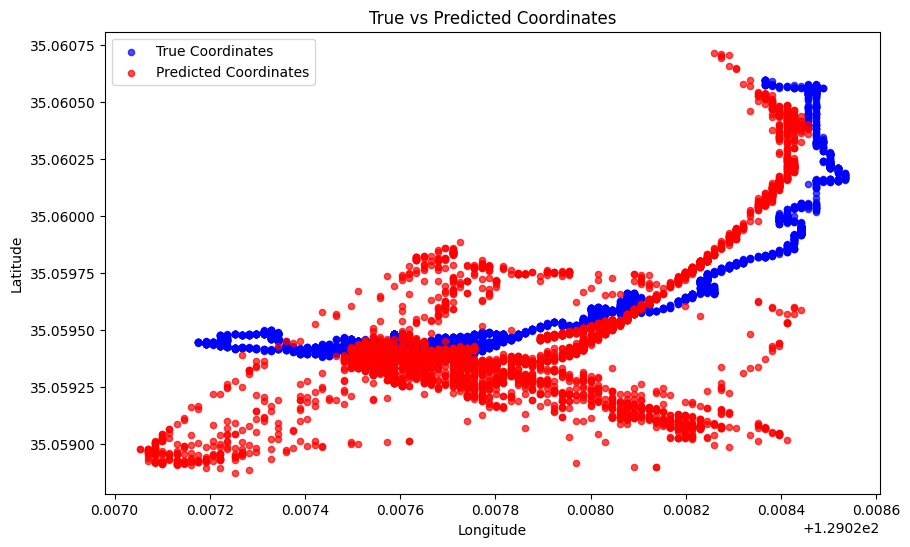

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison['True Lon'], comparison['True Lat'], label='True Coordinates', alpha=0.7, c='blue', s=20)
plt.scatter(comparison['Predicted Lon'], comparison['Predicted Lat'], label='Predicted Coordinates', alpha=0.7, c='red', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.show()


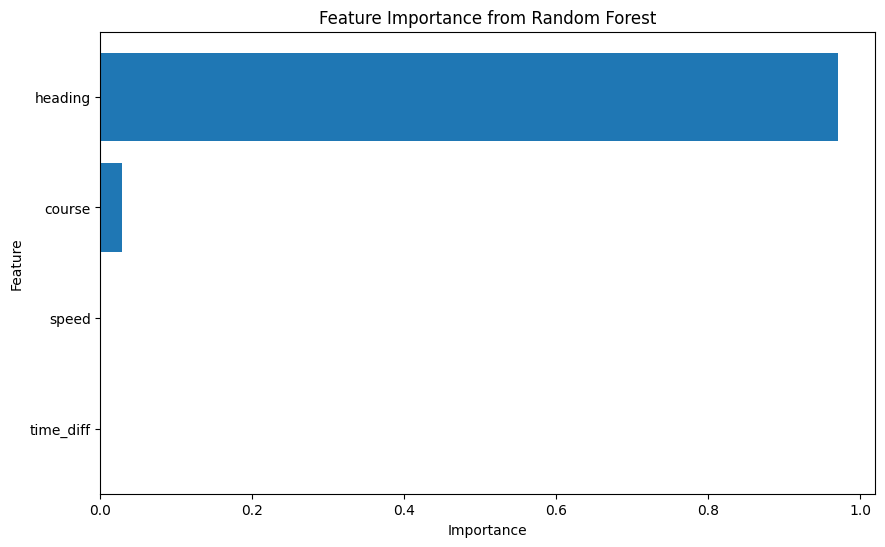

     Feature  Importance
2    heading    0.971645
1     course    0.027870
0      speed    0.000359
3  time_diff    0.000125


In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('../document/filter_ship.csv')

# created_at 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 독립 변수와 종속 변수 설정
independent_columns = ["turn", "speed", "accuracy", "course", "heading", "time_diff"]
target_column = "lat"

# 동일한 값을 가진 변수 제거 (turn, accuracy)
independent_columns = ["speed", "course", "heading", "time_diff"]
X_features = data[independent_columns]
y_target = data[target_column]

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_features, y_target)

# Feature Importance 계산
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": independent_columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()

print(importance_df)
